<a href="https://colab.research.google.com/github/fahaerte/LSIES-FinalAssignment/blob/main/Task4_DataAssimilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
# Environment variables
drive = True
install_packages = False

# If necessary, install packages
if install_packages:
  !pip install Basemap basemap-data-hires
  !pip install pandas matplotlib numpy
  !pip install sklearn
  !pip install datetime

# Imports
import os
import pandas as pd
import numpy as np
from csv import reader
from sklearn.metrics import r2_score
from datetime import datetime
from datetime import timedelta as tdelta
from datetime import time as time
from sklearn.linear_model import LinearRegression
import warnings

# Mount drive if needed
if drive:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Colab\ Notebooks/LSIES

from Helper_funcs import *
from SensorPositions_Func import *
from SVD_Func import *

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Depending on the environemnt, set directory to data
if drive:
  dir_path = '/content/drive/MyDrive/data/'
else :
  dir_path = './data/'

folders = ['region_1_mustamäe_kristiine', 'region_2_data_kesklinn', 'region_3_kadriorg_lasnamäe', 'region_4_ülemiste']
csv_file_name_sensor_positions = 'sensor_positions.csv'
columns_sensors_positions = ['sensor_name', 'latitude', 'longitude', 'region']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/LSIES


In [2]:
#Import data
df_data_incomplete = import_sensor_data(dir_path)

#interpolate data using 'nearest' method
list_df_other = []
list_df_linear = []
list_df_nearest = []

temp_df = df_data_incomplete.interpolate(method='nearest')
df_data_nearest = temp_df.interpolate(limit_area=None, method='backfill')

temp_df = df_data_incomplete.interpolate(method='linear')
df_data_linear = temp_df.interpolate(limit_area=None, method='backfill')
df_data_linear.apply(lambda x: np.round(x, 1), 1);

/content/drive/MyDrive/Colab Notebooks/LSIES/Helper_funcs.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='Time', keep='first', inplace=True)


In [3]:
# Compute indices of timestamps
day_index = compute_period_indices(df_data_linear, '07:00', '19:00')
evening_index = compute_period_indices(df_data_linear, '19:00', '23:00')
night_index = compute_period_indices(df_data_linear, '23:00', '7:00')

In [4]:
# Compute sensor regions
sensor_positions_df = import_sensor_positions(dir_path, csv_file_name_sensor_positions)
sensors_region1, sensors_region2, sensors_region3, sensors_region4 = get_sensors_based_on_region(sensor_positions_df)
del sensor_positions_df, csv_file_name_sensor_positions

In [5]:
# Filter data to obtain only sensors of region 4
data_region4 = df_data_linear[sensors_region4]
del sensors_region1, sensors_region2, sensors_region3, df_data_linear

In [6]:
# Compute average of region 4
data_region4['average'] = data_region4.mean(axis=1)

<ipython-input-6-a9b3cf132f02>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_region4['average'] = data_region4.mean(axis=1)


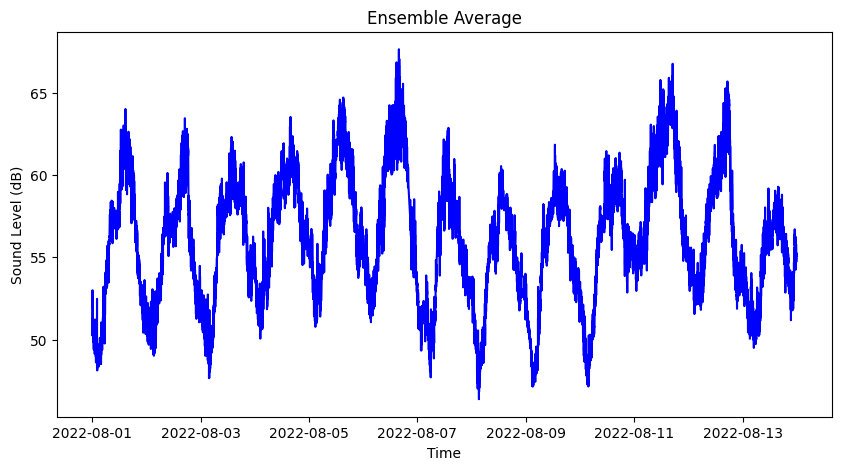

In [14]:
# Plot the ensemble average
plt.figure(figsize=(10,5))
plt.plot(data_region4.index, data_region4['average'],c='blue', label='Ensemble Average')
plt.title('Ensemble Average')
plt.xlabel('Time')
plt.ylabel('Sound Level (dB)')
plt.show()

Let's see how many times certain thresholds are exceeded on average

In [7]:
dba_thresholds = range(55, 70, 1)
cols=['threshold', 'period', '21C2', '221E', '2240', '225D', '2266', '2289', '2329', '2396']
exceeding_threshold_df = pd.DataFrame(columns=cols)
periods = ['day', 'evening', 'night']
indices = [day_index, evening_index, night_index]

for threshold in dba_thresholds:
    for period, index in zip(periods, indices):
        counts = (data_region4.iloc[index][data_region4 >= threshold].count() / index.shape[0] * 100).to_dict()
        counts['period'] = period
        counts['threshold'] = threshold
        exceeding_threshold_df = exceeding_threshold_df.append(counts, ignore_index=True)


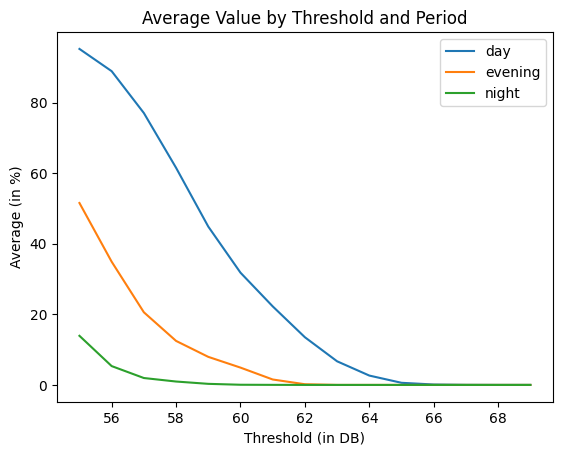

In [8]:
fig, ax = plt.subplots()
for p in exceeding_threshold_df['period'].unique():
  ax.plot(exceeding_threshold_df[exceeding_threshold_df['period']==p]['threshold'], exceeding_threshold_df[exceeding_threshold_df['period']==p]['average'], label=p)

ax.set_xlabel('Threshold (in DB)')
ax.set_ylabel('Average (in %)')
ax.set_title('Average Value by Threshold and Period')
ax.legend()
plt.show()

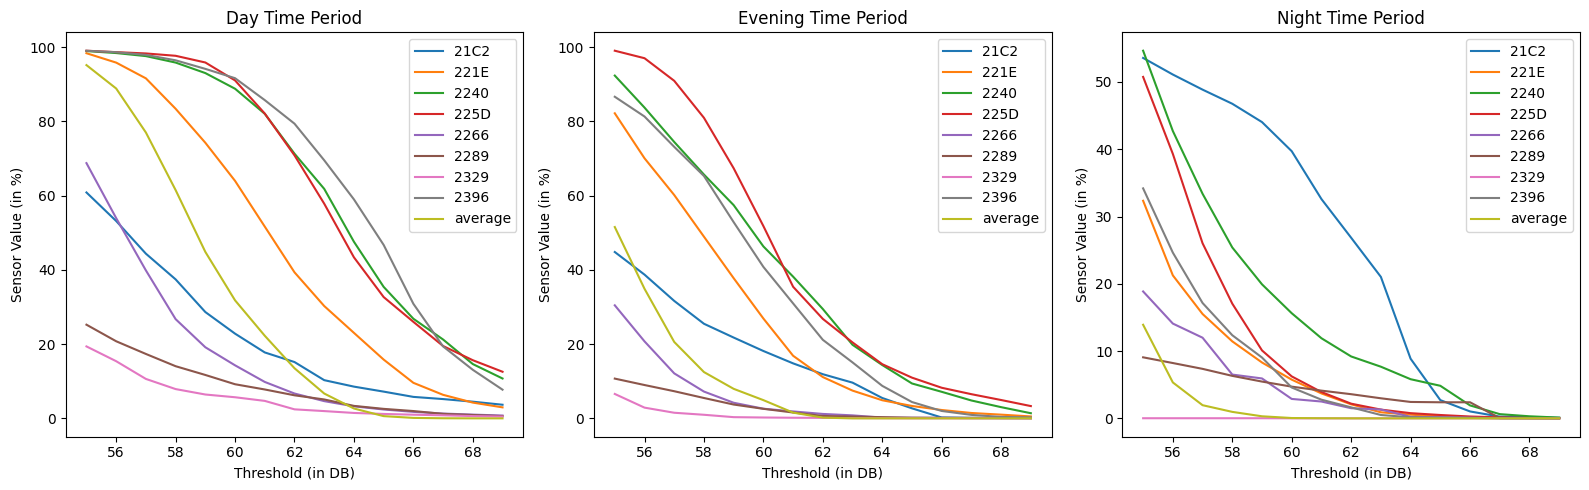

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

for period, ax in zip(exceeding_threshold_df['period'].unique(), axs):
    df_period = exceeding_threshold_df[exceeding_threshold_df['period'] == period]
    
    for sensor in df_period.columns[2:]:
        ax.plot(df_period['threshold'], df_period[sensor], label=sensor)
    
    ax.set_xlabel('Threshold (in DB)')
    ax.set_ylabel('Sensor Value (in %)')
    ax.set_title(f'{period.capitalize()} Time Period')
    ax.legend()

plt.tight_layout()
plt.show()

Probably, the noise disturbance on weekdays is different to the noise disturbance on the weekend. Let's consider it

In [10]:
exceeding_threshold_weekday_df = pd.DataFrame(columns=cols)
exceeding_threshold_weekend_df = pd.DataFrame(columns=cols)

for threshold in dba_thresholds:
    for period, index in zip(periods, indices):
      data_region4_period = data_region4.iloc[index]
      data_region4_weekday = data_region4_period[data_region4_period.index.dayofweek < 5]
      data_region4_weekend = data_region4_period[data_region4_period.index.dayofweek >= 5]
      counts_weekdays = (data_region4_weekday[data_region4_weekday >= threshold].count() / index.shape[0] * 100).to_dict()
      counts_weekends = (data_region4_weekend[data_region4_weekend >= threshold].count() / index.shape[0] * 100).to_dict()
      counts_weekdays['period'] = period
      counts_weekdays['threshold'] = threshold
      counts_weekends['period'] = period
      counts_weekends['threshold'] = threshold
      exceeding_threshold_weekday_df = exceeding_threshold_weekday_df.append(counts_weekdays, ignore_index=True)
      exceeding_threshold_weekend_df = exceeding_threshold_weekend_df.append(counts_weekends, ignore_index=True)


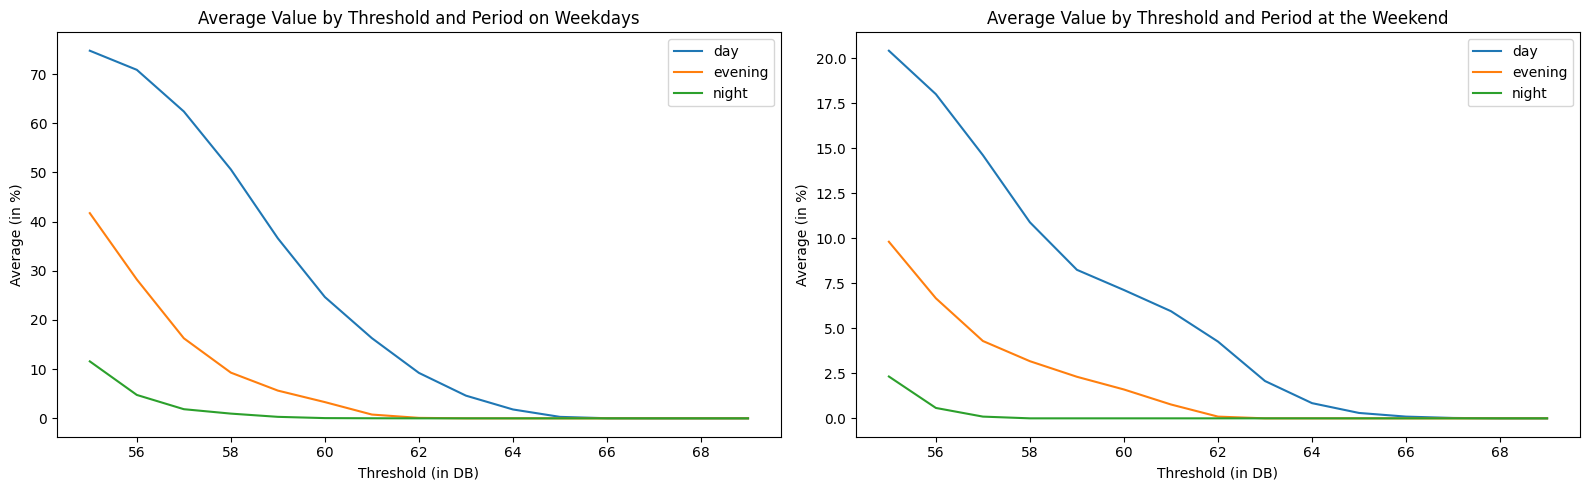

In [11]:
fig, axs = plt.subplots(1,2, figsize=(16, 5))
for p in exceeding_threshold_df['period'].unique():
  axs[0].plot(exceeding_threshold_weekday_df[exceeding_threshold_weekday_df['period']==p]['threshold'], exceeding_threshold_weekday_df[exceeding_threshold_weekday_df['period']==p]['average'], label=p)
  axs[1].plot(exceeding_threshold_weekend_df[exceeding_threshold_weekend_df['period']==p]['threshold'], exceeding_threshold_weekend_df[exceeding_threshold_weekend_df['period']==p]['average'], label=p)

axs[0].set_xlabel('Threshold (in DB)')
axs[0].set_ylabel('Average (in %)')
axs[0].set_title('Average Value by Threshold and Period on Weekdays')
axs[0].legend()
axs[1].set_xlabel('Threshold (in DB)')
axs[1].set_ylabel('Average (in %)')
axs[1].set_title('Average Value by Threshold and Period at the Weekend')
axs[1].legend()

plt.tight_layout()
plt.show()

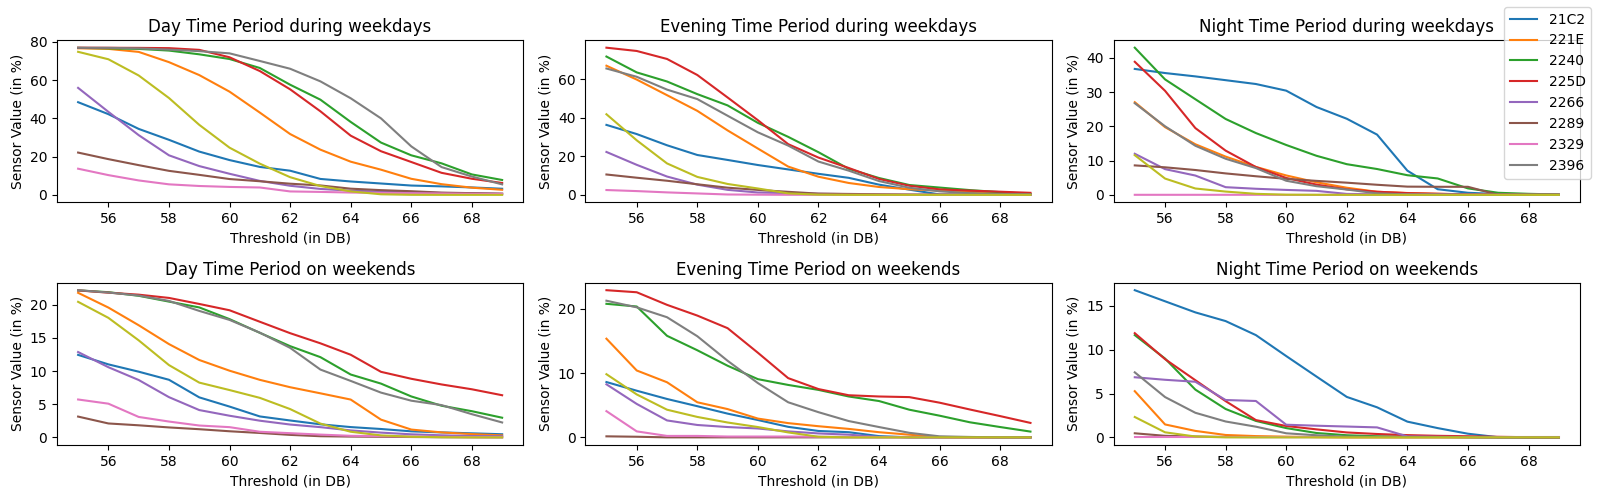

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(16, 5))

for period, ax in zip(exceeding_threshold_weekday_df['period'].unique(), axs[0]):
    df_period = exceeding_threshold_weekday_df[exceeding_threshold_weekday_df['period'] == period]
    
    for sensor in df_period.columns[2:]:
        ax.plot(df_period['threshold'], df_period[sensor], label=sensor)
    
    ax.set_xlabel('Threshold (in DB)')
    ax.set_ylabel('Sensor Value (in %)')
    ax.set_title(f'{period.capitalize()} Time Period during weekdays')

for period, ax in zip(exceeding_threshold_weekend_df['period'].unique(), axs[1]):
    df_period = exceeding_threshold_weekend_df[exceeding_threshold_weekend_df['period'] == period]
    
    for sensor in df_period.columns[2:]:
        ax.plot(df_period['threshold'], df_period[sensor], label=sensor)
    
    ax.set_xlabel('Threshold (in DB)')
    ax.set_ylabel('Sensor Value (in %)')
    ax.set_title(f'{period.capitalize()} Time Period on weekends')

fig.legend(cols[2:])
plt.tight_layout()
plt.show()

**DATA SMOOTHING**

In [54]:
window_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90]
data_smoothed = []

for window in window_sizes:
  data_region4_smoothed = pd.DataFrame()
  data_region4_smoothed = data_region4.rolling(window).mean()
  data_region4_smoothed = data_region4_smoothed[window - 1:] # Remove the first rows since they only contain NaN values
  data_smoothed.append(data_region4_smoothed)

data_smoothed[0].head()

,21C2,221E,2240,225D,2266,2289,2329,2396,average
2022-08-01 00:09:00,54.0,53.0,56.800000,55.1,50.700000,48.0,45.0,48.7,51.412500
2022-08-01 00:10:00,54.0,53.0,57.157143,54.8,50.800000,48.0,45.0,49.7,51.557143
2022-08-01 00:11:00,54.0,53.0,57.971429,55.1,50.800000,48.0,45.0,50.5,51.796429
2022-08-01 00:12:00,54.0,53.0,58.442857,55.1,50.800000,48.0,45.0,50.8,51.892857
2022-08-01 00:13:00,54.0,53.0,58.971429,55.0,50.794118,48.0,45.0,51.2,51.995693


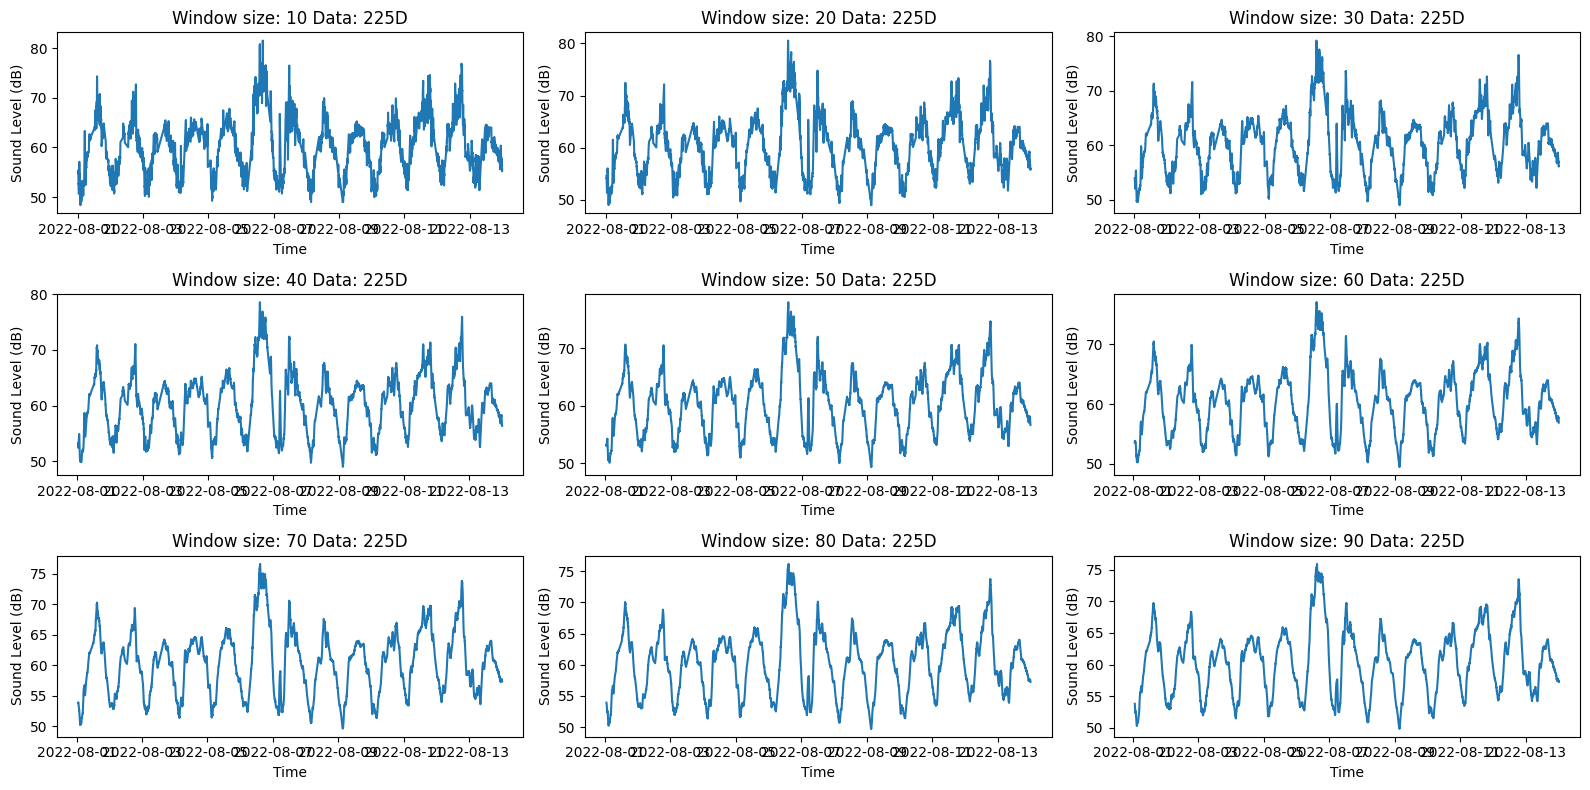

In [52]:
# Plot the smoothed ensemble average
col_to_plot = '225D'
windows_sizes_as_matrix = np.array(window_sizes).reshape(3,3)
fig, axs = plt.subplots(3, 3, figsize=(16, 8))
df_counter = 0

for w1 in range(0, len(windows_sizes_as_matrix)):
  for w2 in range(0, len(windows_sizes_as_matrix[w1])):
        axs[w1, w2].plot(data_smoothed[df_counter].index, data_smoothed[df_counter][col_to_plot])
        axs[w1, w2].set_xlabel('Time')
        axs[w1, w2].set_ylabel('Sound Level (dB)')
        axs[w1, w2].set_title(f'Window size: {windows_sizes_as_matrix[w1, w2]} Data: {col_to_plot}')
        df_counter = df_counter + 1

plt.tight_layout()
plt.show()

Data Smoothing using a window size of 30 minutes is enough to capture the overall trend of the data.

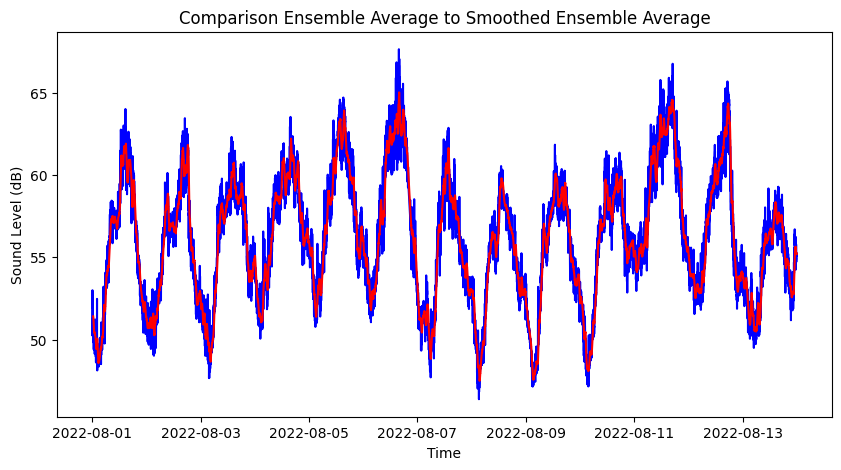

In [64]:
try:
    df_smoothed = data_smoothed[2]
    del data_smoothed, window_sizes, col_to_plot
except NameError:
    pass

plt.figure(figsize=(10,5))
plt.plot(data_region4.index, data_region4['average'],c='blue', label='Ensemble Average')
plt.plot(df_smoothed.index, df_smoothed['average'],c='red', label='Ensemble Average Smoothed')
plt.title('Comparison Ensemble Average to Smoothed Ensemble Average')
plt.xlabel('Time')
plt.ylabel('Sound Level (dB)')
plt.show()

**Data Assimilation - Linear Regression**

Choose 4 sensors next to the Railway station: 

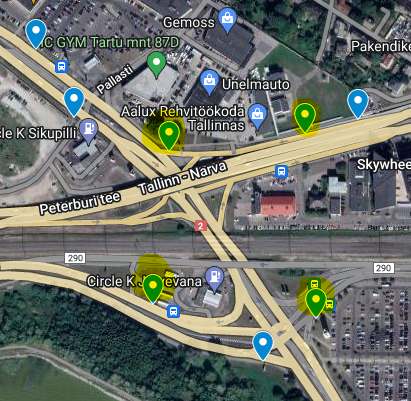

Chosen sensors: 225D, 2396, 2289, 2329

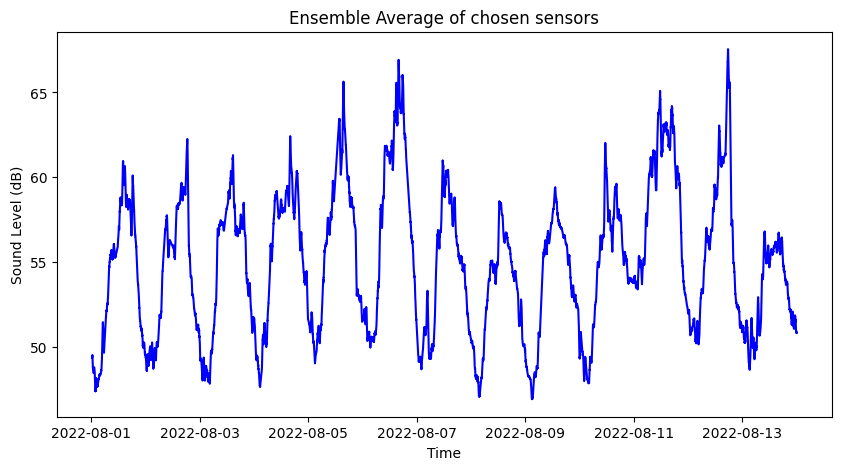

In [71]:
chosen_sensors = ['225D', '2396', '2289', '2329']

# Compute average of chosen sensor
df_chosen_sensors = df_smoothed.loc[:, chosen_sensors]
df_chosen_sensors['average'] = df_chosen_sensors.mean(axis=1)

plt.figure(figsize=(10,5))
plt.plot(df_chosen_sensors.index, df_chosen_sensors['average'],c='blue', label='Ensemble Average')
plt.title('Ensemble Average of chosen sensors')
plt.xlabel('Time')
plt.ylabel('Sound Level (dB)')
plt.show()

Plot the time series based on the period (day, evening, night)

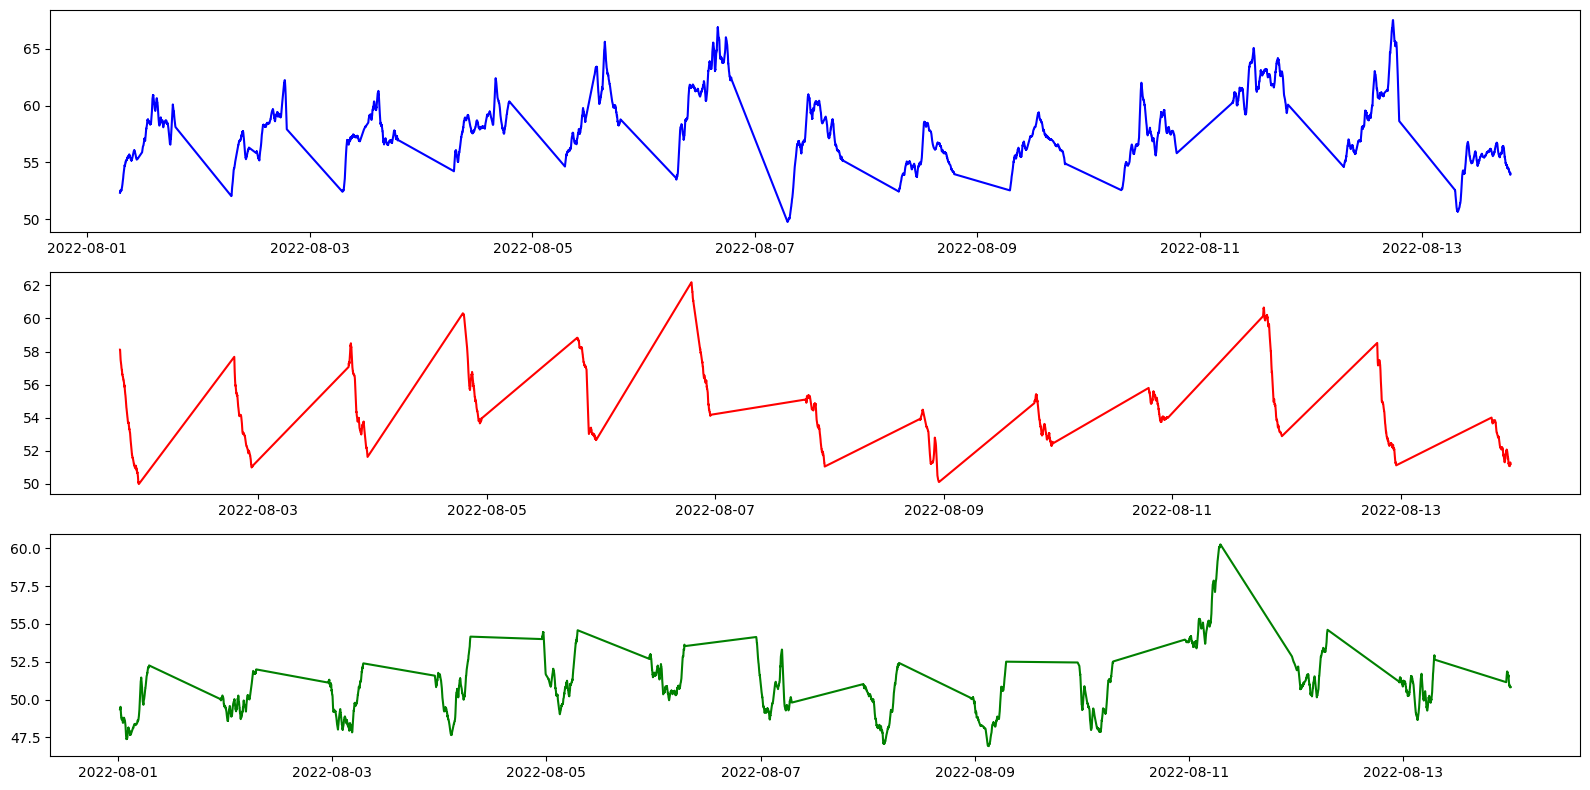

In [82]:
# Compute indices of timestamps
day_index_for_sm_data = compute_period_indices(df_chosen_sensors, '07:00', '19:00')
evening_index_for_sm_data = compute_period_indices(df_chosen_sensors, '19:00', '23:00')
night_index_for_sm_data = compute_period_indices(df_chosen_sensors, '23:00', '7:00')

fig, axs = plt.subplots(3, 1, figsize=(16, 8))
axs[0].plot(df_chosen_sensors.index[day_index_for_sm_data], df_chosen_sensors.iloc[day_index_for_sm_data]['average'],c='blue', label='Ensemble Average - Day Period')
axs[1].plot(df_chosen_sensors.index[evening_index_for_sm_data], df_chosen_sensors.iloc[evening_index_for_sm_data]['average'],c='red', label='Ensemble Average - Evening Period')
axs[2].plot(df_chosen_sensors.index[night_index_for_sm_data], df_chosen_sensors.iloc[night_index_for_sm_data]['average'],c='green', label='Ensemble Average - Night Period')

plt.tight_layout()
plt.show()